<a href="https://colab.research.google.com/github/BelKaty/-Python-Data-Science-Numpy-Matplotlib-Scikit-learn/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

### Курсовой проект

Задание:

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Необходимо получить R2 > 0.6.

Материалы к проекту (файлы):

[train.csv](https://github.com/BelKaty/-Python-Data-Science-Numpy-Matplotlib-Scikit-learn/blob/main/train.csv)

[test.csv](https://github.com/BelKaty/-Python-Data-Science-Numpy-Matplotlib-Scikit-learn/blob/main/test.csv)

**Содержание**
* [Загрузка данных](#load)
* [1. Разведочный анализ данных (EDA)](#eda)
* [2. Обнаружение и обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Генерация новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

In [1]:
# Время работы
import time
start_time = time.time()

# Работа с данными
import numpy as np
import pandas as pd

# Визуализация данных
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Настройки вывода
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.filterwarnings('ignore')

# Обработка данных
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

# Работа с моделями
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

# Прочее
from datetime import datetime
import random as rnd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 10})

In [4]:
def evaluate_predictions(train_true, train_pred, test_true, test_pred):
    train_r2 = round(r2(train_true, train_pred), 3)
    test_r2 = round(r2(test_true, test_pred), 3)

    print(f"Значение R2 на train:\t{train_r2}")
    print(f"Значение R2 на test:\t{test_r2}")

    plt.figure(figsize=(9, 5))

    # Визуализация предсказаний на тренировочном наборе
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=train_pred, y=train_true)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Актуальные значения')
    plt.title(f'Предсказание на train (R2: {train_r2})')

    # Визуализация предсказаний на тестовом наборе
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=test_pred, y=test_true)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Актуальные значения')
    plt.title(f'Предсказание на test (R2: {test_r2})')

    plt.show()

**Путь к файлам**

In [5]:
TEST = '/content/test.csv'
TRAIN = '/content/train.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета:**

**Id** - идентификационный номер квартиры

**DistrictId** - идентификационный номер района

**Rooms** - количество комнат

**Square** - площадь

**LifeSquare** - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности

**Social_1**, **Social_2**, **Social_3** - социальные показатели местности

**Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья

**Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров

**Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.00,50.40,30.48,5.00,6,5.00,1968,0.14,B,B,46,7960,6,350.00,3,11,B,196684.32
9996,6159,18,1.00,41.52,20.54,9.00,13,13.00,2000,0.00,B,B,30,5562,0,NaN,0,5,A,189050.29
9997,5123,27,1.00,47.94,NaN,1.00,12,16.00,2015,0.07,B,B,2,629,1,NaN,0,0,A,159143.81
9998,5400,75,2.00,43.60,33.84,8.00,1,5.00,1961,0.31,B,A,30,5048,9,325.00,2,5,B,181595.34
9999,6306,128,1.00,38.67,21.16,8.00,7,17.00,1990,0.00,B,B,27,4798,0,30.00,2,8,B,218714.08


In [7]:
train_df.dtypes

,0
Id,int64
DistrictId,int64
Rooms,float64
Square,float64
LifeSquare,float64
KitchenSquare,float64
Floor,int64
HouseFloor,float64
HouseYear,int64
Ecology_1,float64


In [8]:
test_df = pd.read_csv(TEST)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.00,67.13,50.81,6.00,5,9.00,1973,0.00,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.00,40.20,21.81,10.00,12,17.00,2017,0.01,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.00,77.84,48.28,9.00,23,22.00,1989,0.09,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.00,81.31,NaN,0.00,4,0.00,1977,0.07,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.00,60.56,NaN,1.00,10,17.00,1977,0.00,B,B,22,6398,141,1046.00,3,23,B


**Размерность данных**


In [9]:
print('Количство строк в трейне:', train_df.shape[0])
print('Количство строк в тесте', test_df.shape[0])

Количство строк в трейне: 10000
Количство строк в тесте 5000


In [10]:
# Проверяем, совпадает ли количество столбцов в данных (train_df, test_df)
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [11]:
train_df.dtypes

,0
Id,int64
DistrictId,int64
Rooms,float64
Square,float64
LifeSquare,float64
KitchenSquare,float64
Floor,int64
HouseFloor,float64
HouseYear,int64
Ecology_1,float64


In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### 1. Разведочный анализ данных (EDA)  <a class='anchor' id='eda'>
Проводим EDA с целью:
*   Обнаружения и исправления выбросов
*   Заполнения пропущенных значений (NaN)
*   Генерации новых признаков (feature engineering)




**Целевая переменная (target)**

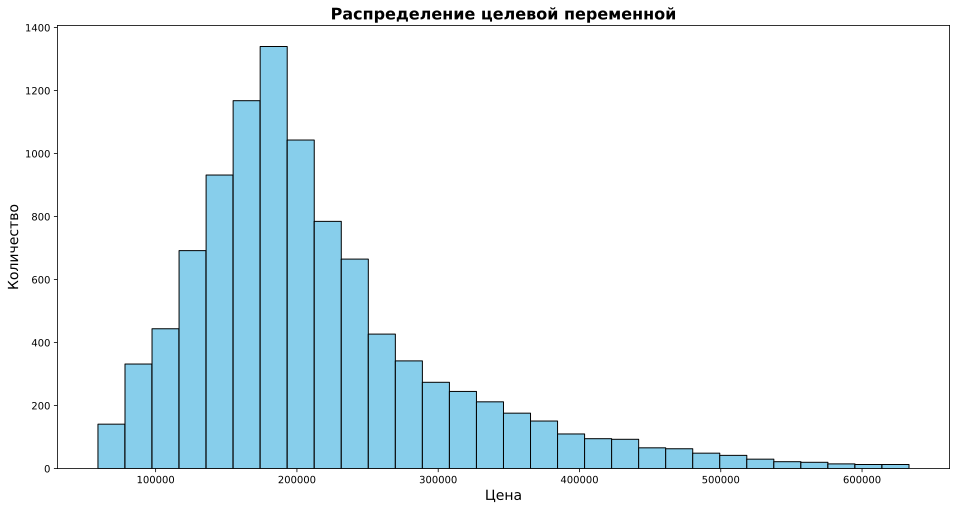

In [13]:
plt.figure(figsize=(16, 8))

train_df['Price'].hist(bins=30, color='skyblue', edgecolor='black')
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Цена', fontsize=14)

plt.title('Распределение целевой переменной', fontsize=16, fontweight='bold')
plt.grid(False)
plt.show()


**Количественные переменные**

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00,10000.00,7887.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,5202.00,10000.00,10000.00,10000.00
mean,1.89,56.32,37.20,6.27,8.53,12.61,3990.17,0.12,24.69,5352.16,8.04,1142.90,1.32,4.23,214138.86
std,0.84,21.06,86.24,28.56,5.24,6.78,200500.26,0.12,17.53,4006.80,23.83,1021.52,1.49,4.81,92872.29
min,0.00,1.14,0.37,0.00,1.00,0.00,1910.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,59174.78
25%,1.00,41.77,22.77,1.00,4.00,9.00,1974.00,0.02,6.00,1564.00,0.00,350.00,0.00,1.00,153872.63
50%,2.00,52.51,32.78,6.00,7.00,13.00,1977.00,0.08,25.00,5285.00,2.00,900.00,1.00,3.00,192269.64
75%,2.00,65.90,45.13,9.00,12.00,17.00,2001.00,0.20,36.00,7227.00,5.00,1548.00,2.00,6.00,249135.46
max,19.00,641.07,7480.59,2014.00,42.00,117.00,20052011.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00,633233.47


**Номинативные переменные**

In [15]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [16]:
train_df['DistrictId'].value_counts()

,count
DistrictId,
27,851
1,652
23,565
6,511
9,294
...,...
207,1
117,1
174,1


In [17]:
train_df['Ecology_2'].value_counts()

,count
Ecology_2,
B,9903
A,97


In [18]:
train_df['Ecology_3'].value_counts()

,count
Ecology_3,
B,9725
A,275


In [19]:
train_df['Shops_2'].value_counts()

,count
Shops_2,
B,9175
A,825


In [20]:
def plot_numeric_distributions(df, frac=0.1):
    """Функция для построения графиков распределений числовых фичей с линией плотности."""

    df_sampled = df.sample(frac=frac)  # Используем подвыборку данных
    numeric_features = df_sampled.select_dtypes(include=['int64', 'float64']).columns

    num_rows_numeric = (len(numeric_features) + 1) // 2
    fig, axes = plt.subplots(num_rows_numeric, 2, figsize=(10, 4 * num_rows_numeric))
    fig.suptitle('Распределение числовых признаков', fontsize=20)

    for i, feature in enumerate(numeric_features):
        row = i // 2
        col = i % 2
        sns.histplot(df_sampled[feature], kde=True, ax=axes[row, col], color='skyblue')
        axes[row, col].set_title(f'Распределение {feature}')
        axes[row, col].set_xlabel('')
        axes[row, col].set_ylabel('')

    if len(numeric_features) % 2 != 0:
        fig.delaxes(axes[num_rows_numeric-1, 1])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

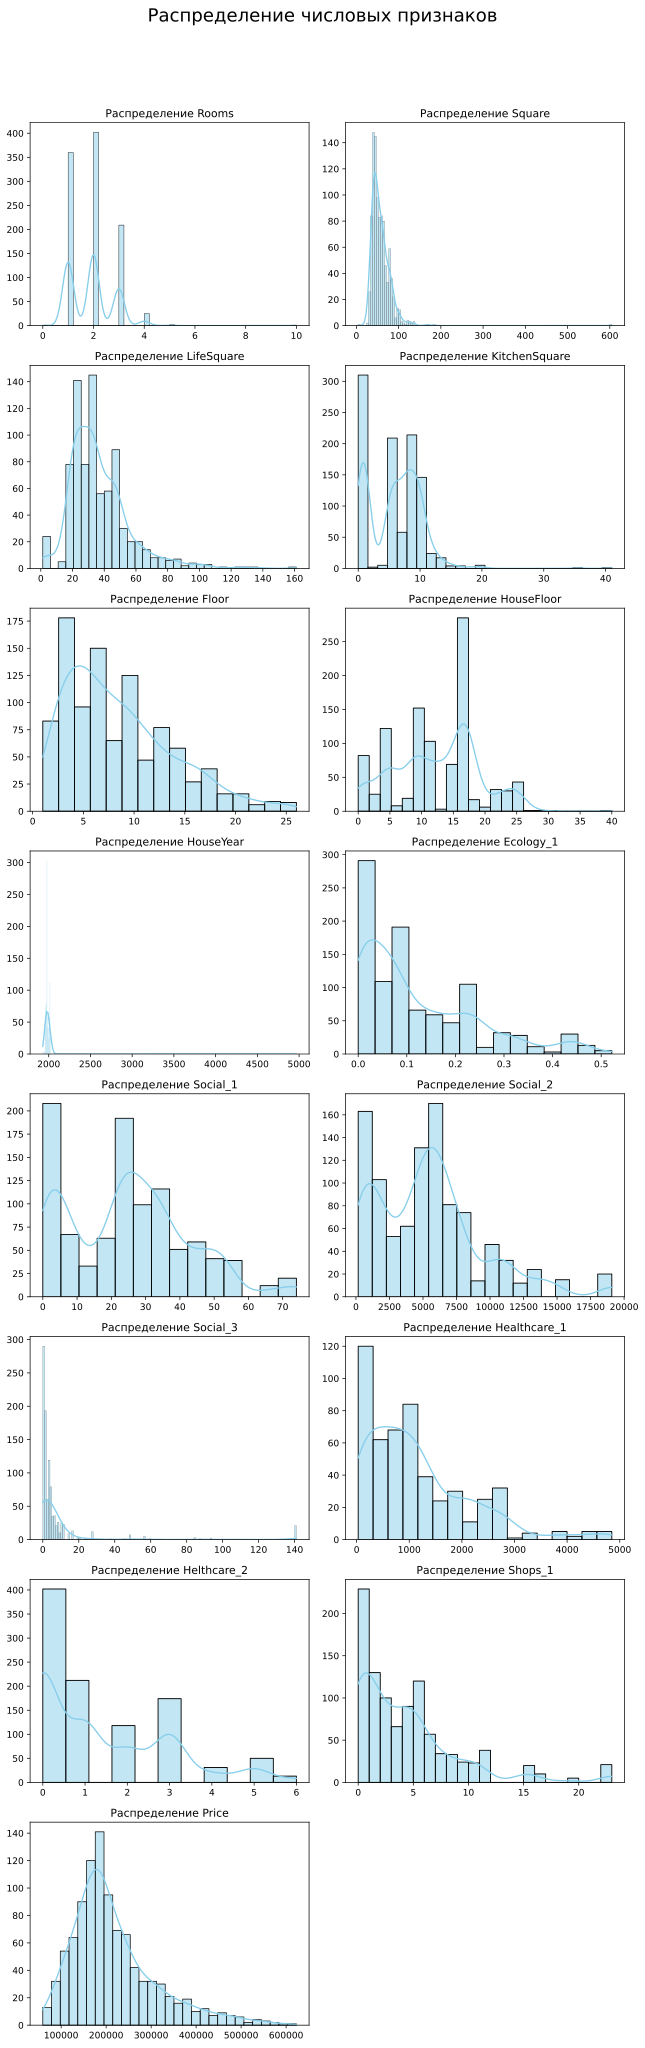

In [21]:
plot_numeric_distributions(train_df)

### 2. Обнаружение и обработка выбросов  <a class='anchor' id='outlier'>


**Rooms**

In [22]:
train_df['Rooms'].value_counts()

,count
Rooms,
2.00,3880
1.00,3705
3.00,2235
4.00,150
5.00,18
0.00,8
10.00,2
19.00,1
6.00,1


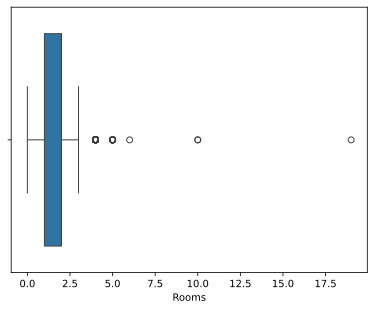

In [23]:
sns.boxplot(data=train_df, x='Rooms')
plt.show()

In [24]:
Q1 = train_df['Rooms'].quantile(0.25)
Q3 = train_df['Rooms'].quantile(0.75)
IQR = Q3 - Q1
train_df['Rooms_outlier'] = ((train_df['Rooms'] < (Q1 - 1.5 * IQR)) | (train_df['Rooms'] > (Q3 + 1.5 * IQR))).astype(int)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,...,B,33,7976,5,NaN,0,11,B,184966.93,0
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,...,B,46,10309,1,240.00,1,16,B,300009.45,0
2,4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,...,B,34,7759,0,229.00,1,3,B,220925.91,0
3,5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,...,B,23,5735,3,1084.00,0,5,B,175616.23,0
4,10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,...,B,35,5776,1,2078.00,2,4,B,150226.53,0


In [25]:
median_rooms = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms_outlier'] == 1, 'Rooms'] = median_rooms

In [26]:
train_df['Rooms'].value_counts()

,count
Rooms,
2.00,4052
1.00,3713
3.00,2235


**KitchenSquare**

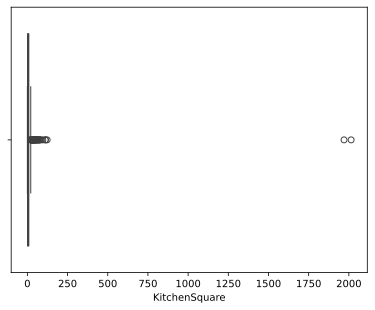

In [27]:
sns.boxplot(data=train_df, x='KitchenSquare')
plt.show()

In [28]:
train_df['KitchenSquare'].value_counts()

,count
KitchenSquare,
1.00,2460
8.00,1306
5.00,1169
10.00,1075
6.00,1038
9.00,843
0.00,697
7.00,609
12.00,249


In [29]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [30]:
# Определяем порог для выбросов
upper_threshold = train_df['KitchenSquare'].quantile(0.975)

# Обрабатываем пропущенные значения и выбросы выше порогового значения
train_df['KitchenSquare'] = train_df['KitchenSquare'].apply(
    lambda x: train_df['KitchenSquare'].median() if pd.isna(x) or x > upper_threshold else x
)

# Обеспечиваем минимальную площадь кухни в 3 квадратных метра
train_df['KitchenSquare'] = train_df['KitchenSquare'].apply(lambda x: max(x, 3))

In [31]:
train_df['KitchenSquare'].value_counts()

,count
KitchenSquare,
3.00,3183
8.00,1306
6.00,1227
5.00,1169
10.00,1075
9.00,843
7.00,609
12.00,249
11.00,233


**HouseFloor, Floor**

In [32]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [33]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [34]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Логически невозможно, чтобы этаж квартиры был выше, чем общее количество этажей в доме. Если такие случаи присутствуют в данных, они считаются аномальными и нуждаются в исправлении.

In [35]:
# Объединяем условия для обнаружения выбросов в столбце 'HouseFloor'
housefloor_condition = (train_df['HouseFloor'] == 0) | (train_df['Floor'] > train_df['HouseFloor'])

# Применяем условие для маркировки выбросов
train_df['HouseFloor_outlier'] = housefloor_condition.astype(int)

In [36]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [37]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
       ...
       9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
      dtype='int64', length=1610)

In [38]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: rnd.randint(1, x))

In [39]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [40]:
train_df['HouseYear'].sort_values(ascending=False)

,HouseYear
1497,20052011
4189,4968
5701,2020
2493,2020
1499,2020
...,...
7611,1916
910,1914
2656,1912
5111,1912


In [41]:
train_df.loc[train_df['HouseYear'] > 2024, 'HouseYear'] = 2024

In [42]:
train_df['HouseYear'].sort_values(ascending=False)

,HouseYear
4189,2024
1497,2024
5701,2020
2493,2020
1499,2020
...,...
7611,1916
910,1914
2656,1912
5111,1912


### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [43]:
train_df.isna().sum()

,0
Id,0
DistrictId,0
Rooms,0
Square,0
LifeSquare,2113
KitchenSquare,0
Floor,0
HouseFloor,0
HouseYear,0
Ecology_1,0


**LifeSquare**

In [44]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.98,29.44,6.00
1,65.68,40.05,8.00
2,44.95,29.20,3.00
3,53.35,52.73,9.00
4,39.65,23.78,7.00
5,80.38,46.68,12.00
6,62.25,37.16,7.00
7,80.31,NaN,3.00
8,64.51,NaN,3.00
9,46.46,18.92,8.00


In [45]:
# Создаем индикатор пропущенных значений в 'LifeSquare'
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isnull().astype(int)

# Определяем условие для заполнения пропущенных значений в 'LifeSquare'
missing_life_square = (
    train_df['LifeSquare'].isnull() &
    train_df['Square'].notnull() &
    train_df['KitchenSquare'].notnull()
)

# Заполняем пропущенные значения в 'LifeSquare'
train_df.loc[missing_life_square, 'LifeSquare'] = (
    train_df.loc[missing_life_square, 'Square'] -
    train_df.loc[missing_life_square, 'KitchenSquare'] - 3
)

**Healthcare_1**

In [46]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [47]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None
        self.binary_to_numbers = {'A': 0, 'B': 1}

    def fit(self, X):
        """Сохранение статистик"""
        X = X.copy()

        # Преобразование категориальных переменных в числовые
        for column in ['Ecology_2', 'Ecology_3', 'Shops_2']:
            X[column] = X[column].map(self.binary_to_numbers)

        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)

    def transform(self, X):
        """Трансформация данных"""
        X = X.copy()

        # Преобразование категориальных переменных в числовые
        for column in ['Ecology_2', 'Ecology_3', 'Shops_2']:
            X[column] = X[column].map(self.binary_to_numbers)

        # Применение статистик
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms_outlier'] == 1, 'Rooms'] = self.medians['Rooms']

        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3

        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: rnd.randint(1, x))

        # HouseYear
        current_year = datetime.now().year
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)

        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & ~X['Square'].isna() & ~X['KitchenSquare'].isna()
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

        X.fillna(self.medians, inplace=True)

        return X


### 4. Генерация новых признаков  <a class='anchor' id='feature'>

In [48]:
# Словарь для замены категорий на числовые значения
binary_to_numbers = {'A': 0, 'B': 1}

# Список столбцов, которые нужно заменить
columns_to_replace = ['Ecology_2', 'Ecology_3', 'Shops_2']

# Применение замены для каждого столбца в списке
for column in columns_to_replace:
    train_df[column] = train_df[column].map(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [49]:
dist_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

dist_size.head()

,DistrictSize,count
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [50]:
dist_size = dist_size.rename(columns={'DistrictSize':'DistrictId', 'count':'DistrictSize'})
dist_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [51]:
train_df = train_df.merge(dist_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,...,7976,5,0,11,1,184966.93,0,0,0,22
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,...,10309,1,1,16,1,300009.45,0,0,0,87
2,4765,53,2.00,44.95,29.20,3.00,8,12.00,1968,0.05,...,7759,0,1,3,1,220925.91,0,0,0,174
3,5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,...,5735,3,0,5,1,175616.23,0,0,0,179
4,10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,...,5776,1,2,4,1,150226.53,0,0,0,97


In [52]:
(train_df['DistrictSize'] > 100).value_counts()

,count
DistrictSize,
True,5069
False,4931


In [53]:
train_df['LargeDistrict'] = (train_df['DistrictSize'] > 100).astype(int)

In [54]:
# Группировка данных по району и количеству комнат, расчет медианной цены и переименование столбца
med_price_by_district = (train_df
                         .groupby(['DistrictId', 'Rooms'], as_index=False)
                         .agg(MedPriceByDistrict=('Price', 'median')))

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.00,142799.43
1,0,2.00,176210.81
2,0,3.00,300610.36
3,1,1.00,146735.67
4,1,2.00,202706.09


In [55]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,LargeDistrict,MedPriceByDistrict
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,...,0,11,1,184966.93,0,0,0,22,0,212187.94
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,...,1,16,1,300009.45,0,0,0,87,0,300009.45
2,4765,53,2.00,44.95,29.20,3.00,8,12.00,1968,0.05,...,1,3,1,220925.91,0,0,0,174,1,263206.22
3,5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,...,0,5,1,175616.23,0,0,0,179,1,166809.67
4,10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,...,2,4,1,150226.53,0,0,0,97,0,158539.05


In [56]:
class FeatureGenerator:
    """Генерация новых фич"""

    def __init__(self):
        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.district_size = None
        self.med_price_by_district = None
        self.med_price_by_district_median = None

    def fit(self, X, y=None):
        """Запоминает статистики и формирует фичи на основе обучающих данных"""
        X = X.copy()

        # Генерация фичи DistrictSize
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                                .rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})

        # Исправление названий столбцов
        self.district_size = self.district_size.rename(columns={'DistrictSize': 'DistrictId', 'count': 'DistrictSize'})

        # Генерация фичи MedPriceByDistrict
        if y is not None:
            X['Price'] = y
            self.med_price_by_district = (X.groupby(['DistrictId', 'Rooms'], as_index=False)
                                          .agg(MedPriceByDistrict=('Price', 'median')))
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()

    def transform(self, X):
        """Применяет созданные фичи к новым данным"""
        X = X.copy()



        # Добавление фичи DistrictSize и LargeDistrict
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['LargeDistrict'] = (X['DistrictSize'] > 100).astype(int)

        # Добавление фичи MedPriceByDistrict
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)

        return X


### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [57]:
# Определение списка исходных признаков
base_features = [
    'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
    'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
    'Helthcare_2', 'Shops_1', 'Shops_2'
]

# Определение списка новых сгенерированных признаков
generated_features = [
    'Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan',
    'DistrictSize', 'LargeDistrict', 'MedPriceByDistrict'
]

# Определение целевой переменной
target_variable = 'Price'


### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [58]:
train_df = pd.read_csv(TRAIN)
test_df = pd.read_csv(TEST)

X = train_df.drop(columns=target_variable)
y = train_df[target_variable]

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [60]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 22), (3000, 22), (5000, 22))

In [61]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

In [62]:
%%time
rf_model = RandomForestRegressor(random_state=21, criterion='squared_error')
rf_model.fit(X_train, y_train)

CPU times: user 8.77 s, sys: 88.3 ms, total: 8.85 s
Wall time: 12.8 s


RandomForestRegressor(random_state=21)

Значение R2 на train:	0.961
Значение R2 на test:	0.708


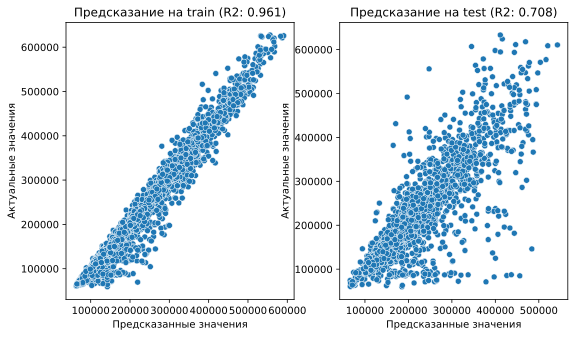

In [63]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_predictions(y_train, y_train_preds, y_valid, y_test_preds)

In [64]:
%%time
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

CPU times: user 16.2 s, sys: 107 ms, total: 16.3 s
Wall time: 16.4 s


array([0.70659895, 0.70787397, 0.73034956])

In [65]:
cv_score.mean()

0.7149408289605411

Благодаря использованию кросс-валидации увеличили эффективность r2 до 71,3%

In [66]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.39
13,Social_2,0.11
12,Social_1,0.08
2,Rooms,0.07
14,Social_3,0.06
1,DistrictId,0.05
9,Ecology_1,0.04
4,LifeSquare,0.04
8,HouseYear,0.03
0,Id,0.03


Видно, что Площадь квартивы самый важный параметр, т.к. его влияние на выбор порядка 39% относительно остальных. Также важную роль играет наличие социальной среды.

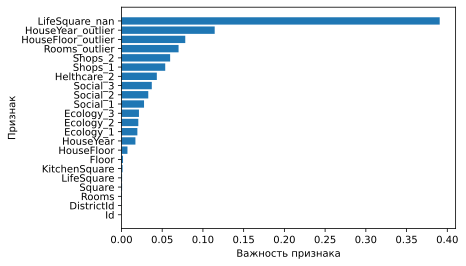

In [67]:
# Задаем размер фигуры
plt.rcParams['figure.figsize'] = 6, 4
# Задаём данные для отрисовки
plt.barh(X_train.keys().tolist(), np.sort(rf_model.feature_importances_))
# Подписываем оси
plt.xlabel("Важность признака")
plt.ylabel("Признак")

plt.show()

**Построение модели с новыми фичами**

In [68]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 25), (3000, 25), (5000, 25))

In [69]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 3, 11)

In [70]:
X_valid.fillna(method='ffill', inplace=True)
test_df.fillna(method='ffill', inplace=True)

In [71]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [72]:
%%time
rf_model = RandomForestRegressor(random_state=21, criterion='squared_error')
rf_model.fit(X_train, y_train)

CPU times: user 9.46 s, sys: 36.7 ms, total: 9.5 s
Wall time: 9.64 s


RandomForestRegressor(random_state=21)

Значение R2 на train:	0.966
Значение R2 на test:	0.687


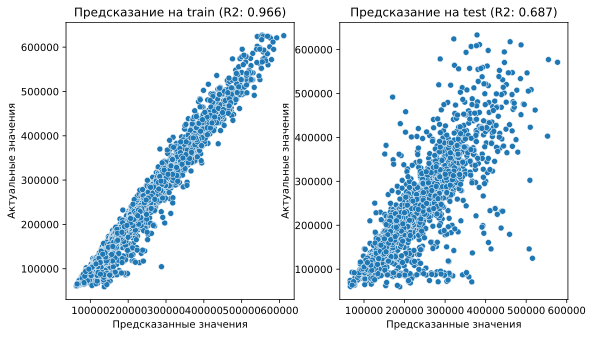

In [73]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_predictions(y_train, y_train_preds, y_valid, y_test_preds)

Исследуя показатели модели с учетом новых признаков, видим, что на тренировочной выборке результат улучшился на 0,5%, до 96,6. На валидационной результат снизился на 0,2% до 68,9.

In [74]:
%%time
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

CPU times: user 18.3 s, sys: 79.9 ms, total: 18.4 s
Wall time: 18.5 s


array([0.73273988, 0.73597716, 0.77520914])

In [75]:
cv_score.mean()

0.747975393054538

Для тестовых данных лучше использовать кросс-валидацию, т.к. ее эффективность выше и составляет 74,8%

In [76]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
24,MedPriceByDistrict,0.64
3,Square,0.12
4,LifeSquare,0.03
0,Id,0.03
8,HouseYear,0.02
14,Social_3,0.02
5,KitchenSquare,0.02
6,Floor,0.02
22,DistrictSize,0.02
7,HouseFloor,0.02


Сейчас важнейшим признаком стала Средняя цена квартиры по району с учетом количества комнат.

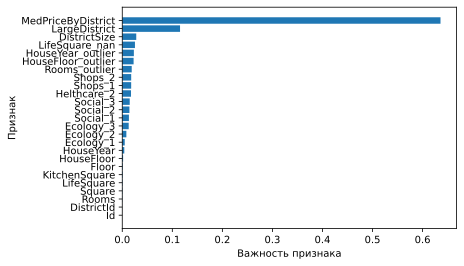

In [77]:
# Задаем размер фигуры
plt.rcParams['figure.figsize'] = 6, 4
# Задаём данные для отрисовки
plt.barh(X_train.keys().tolist(), np.sort(rf_model.feature_importances_))
# Подписываем оси
plt.xlabel("Важность признака")
plt.ylabel("Признак")

plt.show()

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

In [78]:
# Посмотрим размерность датасета
test_df.shape

(5000, 25)

In [79]:
# Выполняем предикт
predictions = rf_model.predict(test_df)
predictions

array([158504.48547789, 230588.84516637, 265319.15492253, ...,
       314733.09027002, 192458.4130175 , 182527.34879169])

In [80]:
# Запишем в датасет Id и Price
df_predict = pd.DataFrame()
df_predict['Id'] = test_df['Id']
df_predict['Price'] = predictions

# Посмотрим, что получилось
df_predict.head()

,Id,Price
0,725,158504.49
1,15856,230588.85
2,5480,265319.15
3,15664,315516.54
4,14275,147306.79


Запишем в CSV файл [predict.csv](https://github.com/BelKaty/-Python-Data-Science-Numpy-Matplotlib-Scikit-learn/blob/main/predict.csv)

In [81]:
df_predict.to_csv('./predict.csv', encoding='utf-8')

# Итоговые выводы и завершение


Самый  лучший результат метрики r2 мы получили 74,8, что соответствует заданию проекта. Это хорошая точность для произвольного датасета. Чтобы улучшить прогнозирование, необходимо улучшать качество данных, их анализа, пробовать другие модели обучения.

In [82]:
print(f"Время выполнения всего процесса: {time.time() - start_time} секунд")

Время выполнения всего процесса: 86.14859318733215 секунд


Отработка проекта заняла 1 минуту 26 секунд, что соответствует заданию.